In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Input

In [3]:
# Download real stock data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN']  # You can change this list!
data = yf.download(tickers, start='2020-01-01', end='2023-12-31')['Close']
data = data.fillna(method='ffill')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed
C:\Users\ADITI MISHRA\AppData\Local\Temp\ipykernel_3120\204338204.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [4]:
# Sequence Preparation
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [5]:
# Model Training & Prediction Function
def train_model(data, model_type='LSTM', seq_length=50):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))

    train_size = int(len(scaled_data) * 0.8)
    train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)

    if model_type in ['Dense', 'RF', 'XGB']:
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)
    else:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    if model_type == 'LSTM':
        model = Sequential([
            Input(shape=(seq_length, 1)),
            LSTM(50, return_sequences=True),
            Dropout(0.2),
            LSTM(50),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, batch_size=16, epochs=10, verbose=0)
        predicted = model.predict(X_test)

    elif model_type == 'GRU':
        model = Sequential([
            Input(shape=(seq_length, 1)),
            GRU(50, return_sequences=True),
            Dropout(0.2),
            GRU(50),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, batch_size=16, epochs=10, verbose=0)
        predicted = model.predict(X_test)

    elif model_type == 'RNN':
        model = Sequential([
            Input(shape=(seq_length, 1)),
            SimpleRNN(50, return_sequences=True),
            Dropout(0.2),
            SimpleRNN(50),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, batch_size=16, epochs=10, verbose=0)
        predicted = model.predict(X_test)

    elif model_type == 'Dense':
        model = Sequential([
            Input(shape=(X_train.shape[1],)),
            Dense(100, activation='relu'),
            Dense(25),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, batch_size=16, epochs=10, verbose=0)
        predicted = model.predict(X_test)

    elif model_type == 'RF':
        model = RandomForestRegressor(n_estimators=100)
        model.fit(X_train, y_train)
        predicted = model.predict(X_test).reshape(-1, 1)

    elif model_type == 'XGB':
        model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror')
        model.fit(X_train, y_train)
        predicted = model.predict(X_test).reshape(-1, 1)

    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(real_prices, predicted_prices)
    mae = mean_absolute_error(real_prices, predicted_prices)
    r2 = r2_score(real_prices, predicted_prices)

    return real_prices, predicted_prices, mse, mae, r2

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step
1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001DBB1C1E5C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


C:\Users\ADITI MISHRA\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


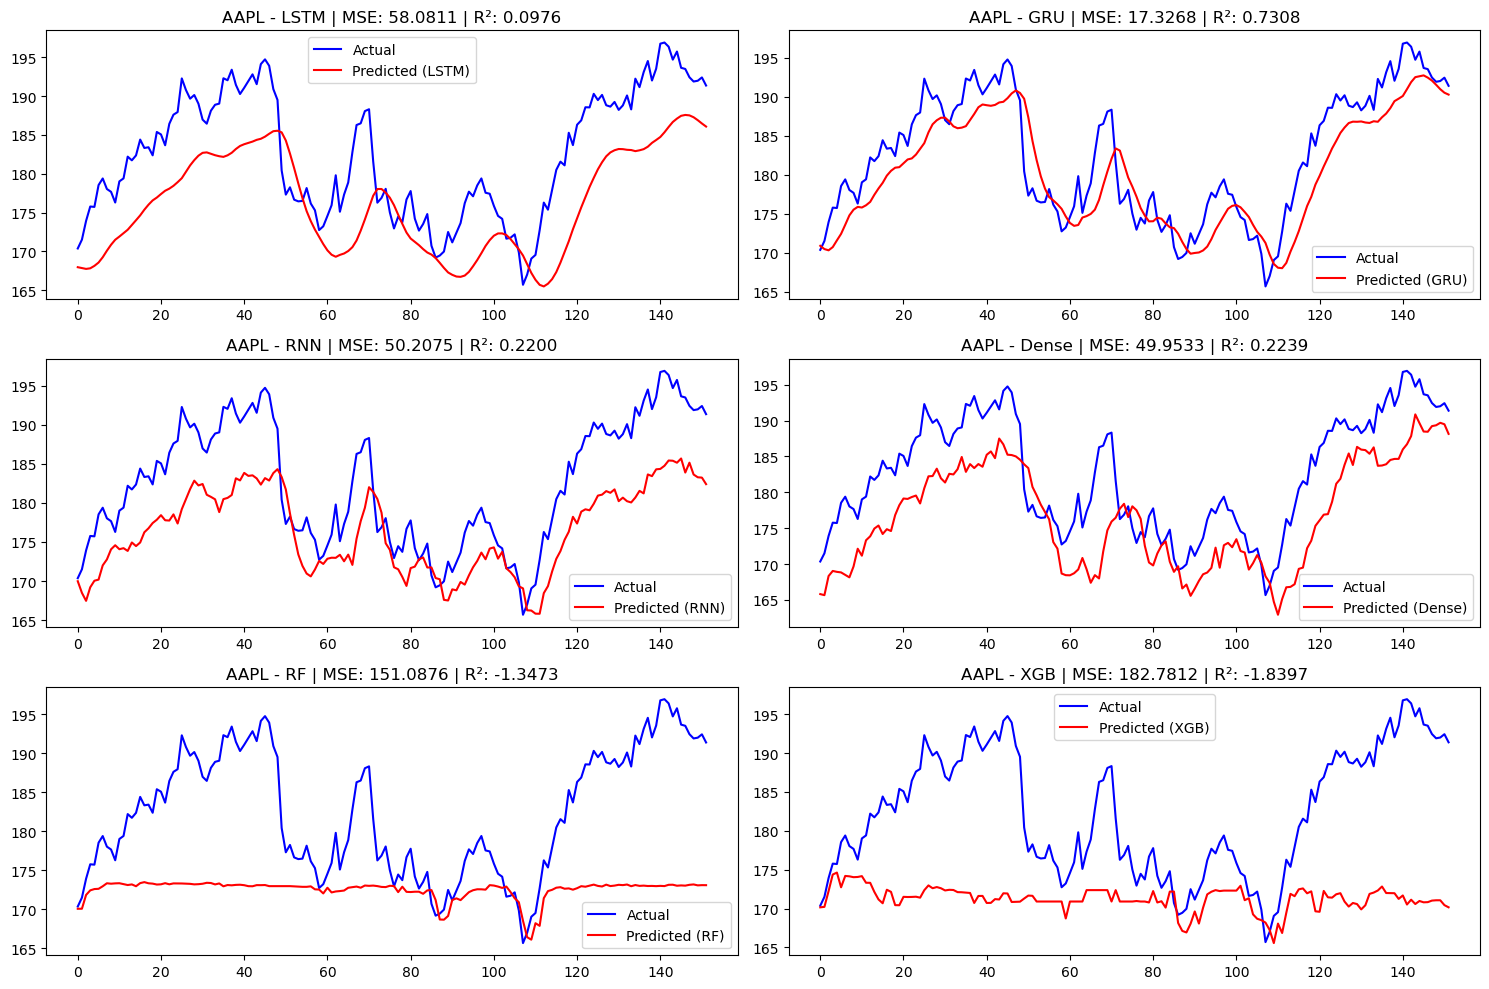

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


C:\Users\ADITI MISHRA\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


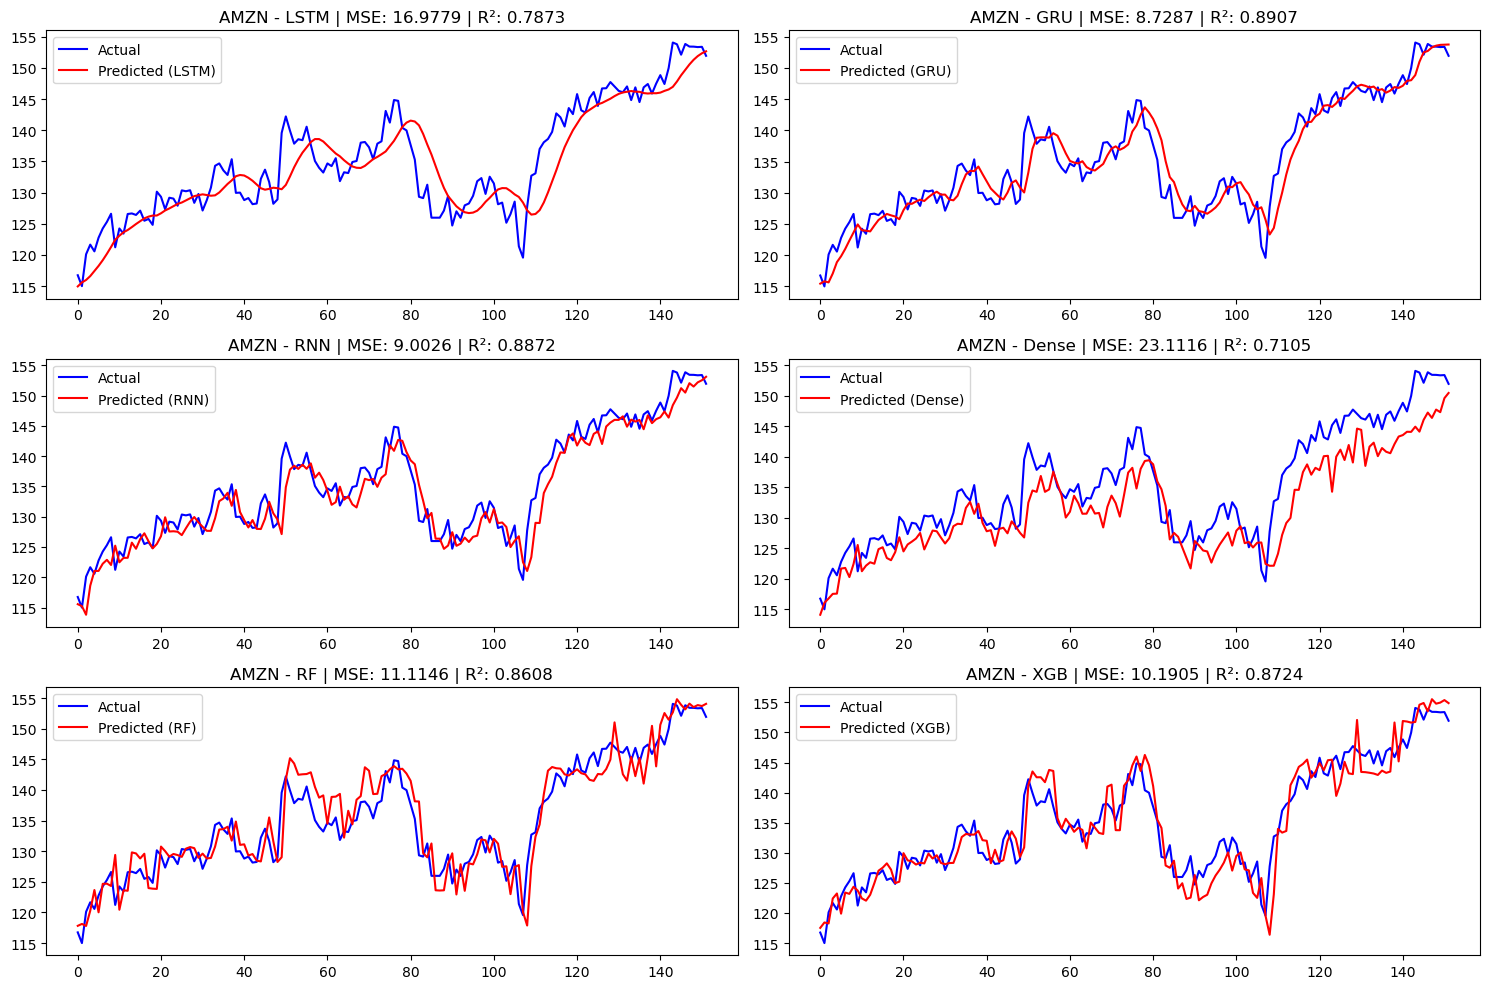

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


C:\Users\ADITI MISHRA\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


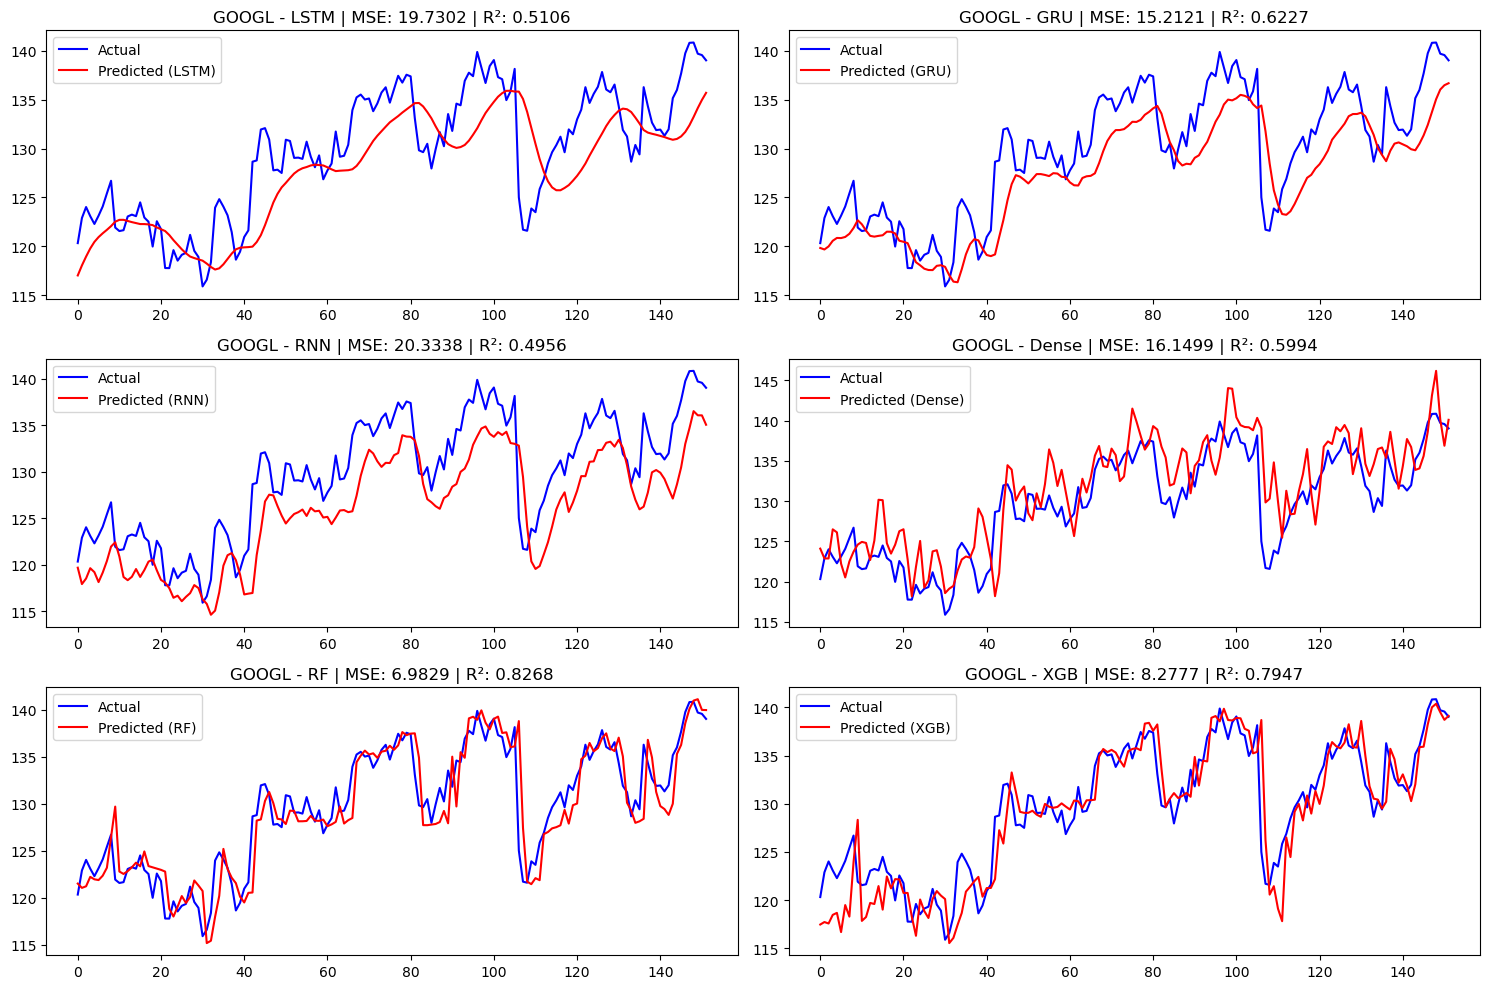

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\ADITI MISHRA\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


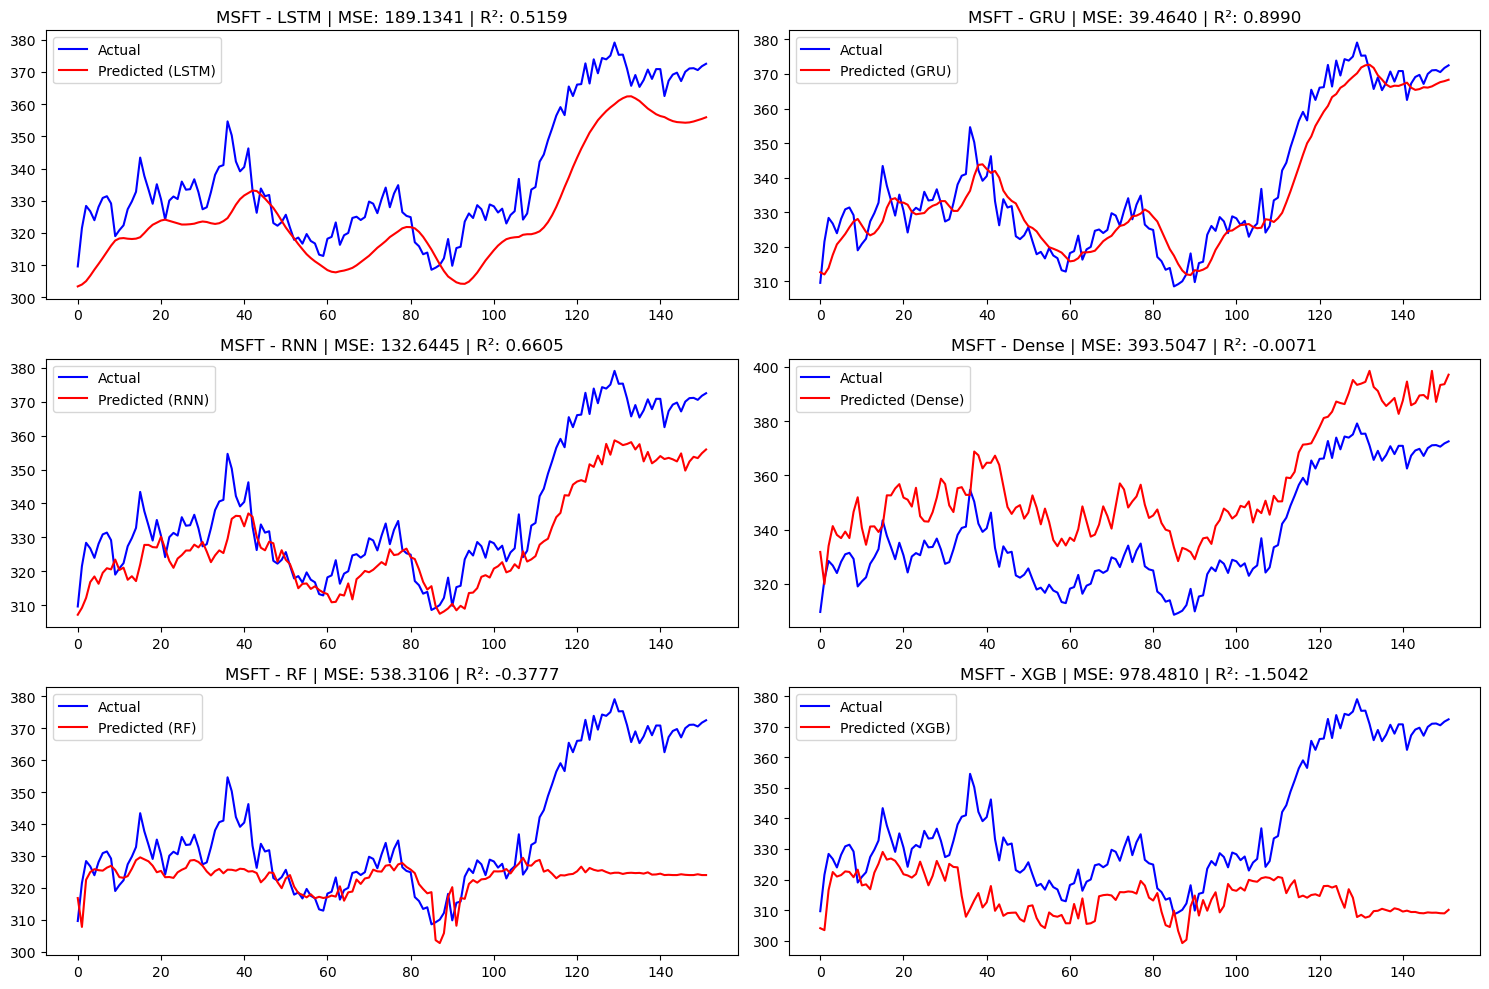

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


C:\Users\ADITI MISHRA\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


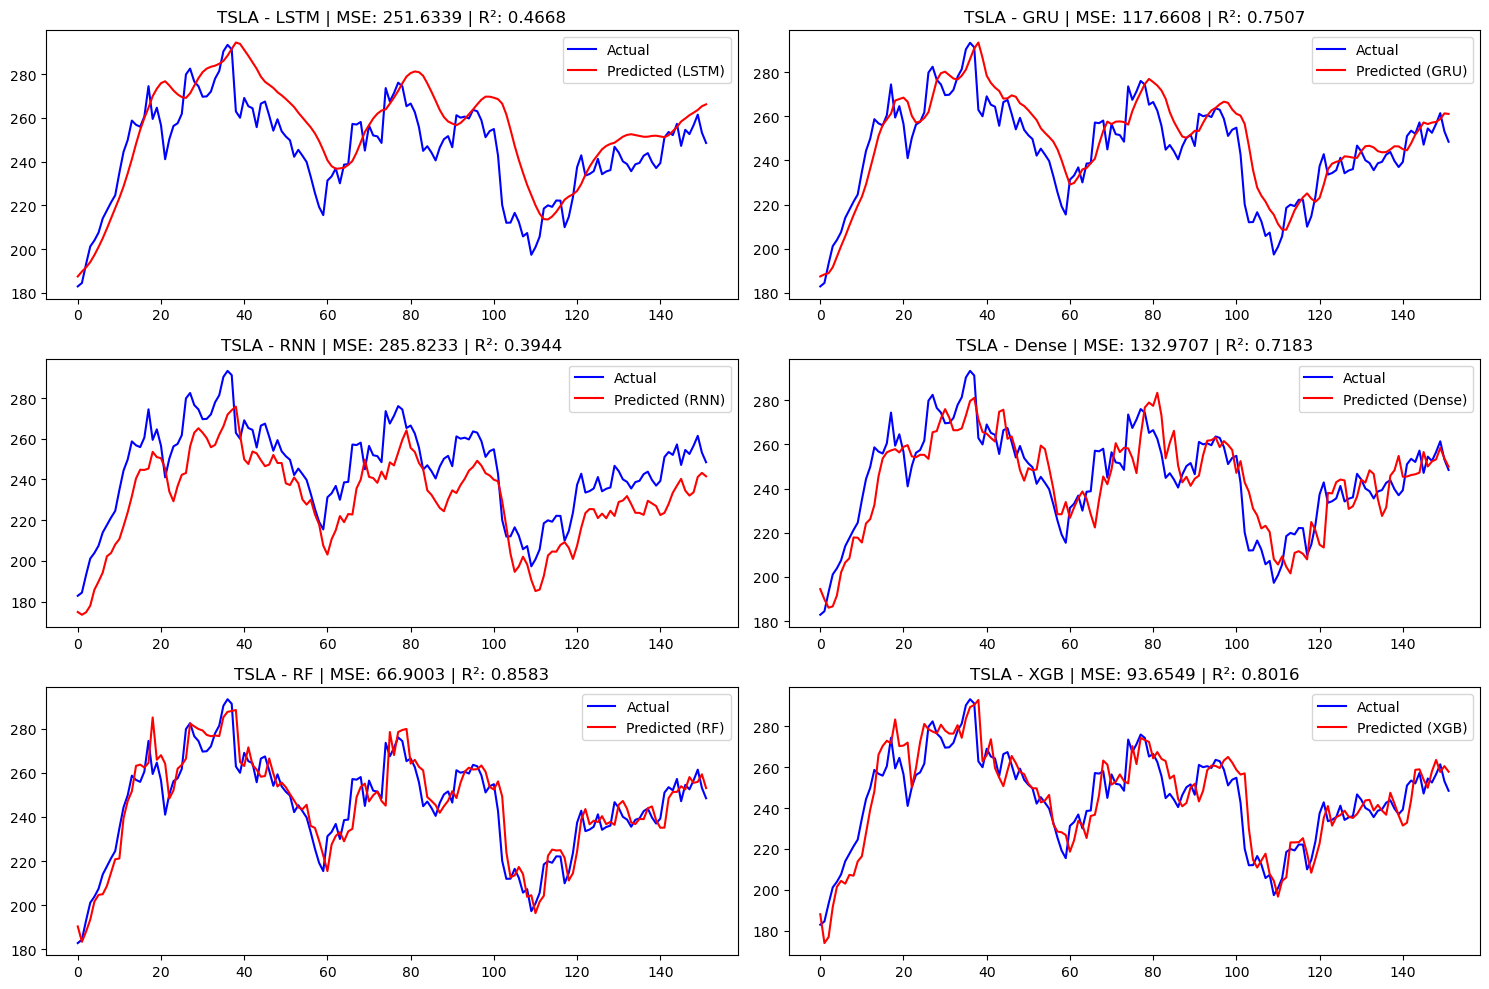

In [6]:
# Plot and Evaluate for Each Stock
results = []

for stock in data.columns:
    stock_data = data[stock].values
    model_list = ['LSTM', 'GRU', 'RNN', 'Dense', 'RF', 'XGB']

    plt.figure(figsize=(15, 10))
    for i, model_name in enumerate(model_list):
        actual, predicted, mse, mae, r2 = train_model(stock_data, model_type=model_name)
        plt.subplot(3, 2, i + 1)
        plt.plot(actual, label='Actual', color='blue')
        plt.plot(predicted, label=f'Predicted ({model_name})', color='red')
        plt.title(f"{stock} - {model_name} | MSE: {mse:.4f} | R²: {r2:.4f}")
        plt.legend()
        results.append({'Stock': stock, 'Model': model_name, 'MSE': mse, 'MAE': mae, 'R2': r2})

    plt.tight_layout()
    plt.show()

In [7]:
# Tabular Summary
results_df = pd.DataFrame(results)
print(results_df)

    Stock  Model         MSE        MAE        R2
0    AAPL   LSTM   58.081074   6.748192  0.097645
1    AAPL    GRU   17.326778   3.506151  0.730809
2    AAPL    RNN   50.207509   6.234673  0.219970
3    AAPL  Dense   49.953287   6.215168  0.223919
4    AAPL     RF  151.087578   9.976887 -1.347316
5    AAPL    XGB  182.781162  11.186778 -1.839711
6    AMZN   LSTM   16.977871   3.205654  0.787339
7    AMZN    GRU    8.728742   2.252231  0.890666
8    AMZN    RNN    9.002633   2.299489  0.887235
9    AMZN  Dense   23.111589   3.986893  0.710510
10   AMZN     RF   11.114552   2.623603  0.860782
11   AMZN    XGB   10.190462   2.572697  0.872357
12  GOOGL   LSTM   19.730183   3.556584  0.510600
13  GOOGL    GRU   15.212115   3.232031  0.622669
14  GOOGL    RNN   20.333812   3.949877  0.495627
15  GOOGL  Dense   16.149922   3.211154  0.599407
16  GOOGL     RF    6.982918   1.840489  0.826791
17  GOOGL    XGB    8.277735   2.062540  0.794674
18   MSFT   LSTM  189.134087  11.868118  0.515945
